# Hands-On AdaBoost 
***

In this notebook we'll implement the AdaBoost learning algorithm using Decision Stumps as the weak learner.  We'll then use our code on a Handwritten Digit Recognition task.


In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone 
import matplotlib.pylab as plt 
%matplotlib inline 

### Part 1: Threes and Eights 
***

In this notebook we'll use the downsampled version of MNIST that you used in Homework 4.  Since the flavor of AdaBoost that we'll implement here is inherently binary, we'll subset the dataset into images of $3$'s and $8$'s.  The following class will load and subset the data. 


In [2]:
class ThreesAndEights:
    """
    Class to store MNIST 3s and 8s data
    """

    def __init__(self, location):

        import pickle, gzip

        # Load the dataset
        f = gzip.open(location, 'rb')

        # Split the data set 
        X_train, y_train, X_valid, y_valid = pickle.load(f)

        # Extract only 3's and 8's for training set 
        self.X_train = X_train[np.logical_or(y_train==3, y_train == 8), :]
        self.y_train = y_train[np.logical_or(y_train==3, y_train == 8)]
        self.y_train = np.array([1 if y == 8 else -1 for y in self.y_train])
        
        # Shuffle the training data 
        shuff = np.arange(self.X_train.shape[0])
        np.random.shuffle(shuff)
        self.X_train = self.X_train[shuff,:]
        self.y_train = self.y_train[shuff]

        # Extract only 3's and 8's for validation set 
        self.X_valid = X_valid[np.logical_or(y_valid==3, y_valid == 8), :]
        self.y_valid = y_valid[np.logical_or(y_valid==3, y_valid == 8)]
        self.y_valid = np.array([1 if y == 8 else -1 for y in self.y_valid])
        
        f.close()
        
def view_digit(ex, label=None, feature=None):
    """
    function to plot digit examples 
    """
    if label: print("true label: {:d}".format(label))
    img = ex.reshape(21,21)
    col = np.dstack((img, img, img))
    if feature is not None: col[feature[0]//21, feature[0]%21, :] = [1, 0, 0]
    plt.imshow(col)
    plt.xticks([]), plt.yticks([])

Execute the following cell to load the data.  Then use the `view_digit` function to plot a few examples.  Which numerical labels are assigned to which class?  Does the choice of labels make sense if we plan to implement AdaBoost? 

In [3]:
data = ThreesAndEights("data/mnist21x21_3789.pklz")

true label: -1


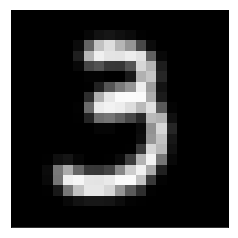

In [4]:
ind = 3
view_digit(data.X_train[ind,:], label=data.y_train[ind])

### Part 2: Decision Stumps for MNIST 
***

So what exactly happens if we use a Decision Stump to classify handwritten digits?  Recall that a Decision Stump is simply a Decision Tree with a split on a single feature.  Experiment with the [DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) from sklearn with the `max_depth` parameter set to `1`.  How well does it perform?  Can you determine what feature is being split on?  How can we interpret this in terms of images of handwritten digits? 

In [5]:
h = DecisionTreeClassifier(max_depth=1)

### Part 3: Implementing AdaBoost  
***

We've given you a skeleton of the class `AdaBoost` below which will train a classifier based on boosted Decision Stumps as implemented by sklearn. Take a look at the class skeleton first so that you understand the underlying organization and data structures that we'll be using.  

In [9]:
class AdaBoost:
    def __init__(self, n_learners=20, base=DecisionTreeClassifier(max_depth=1), random_state=1234):
        """
        Create a new adaboost classifier.
        
        Args:
            N (int, optional): Number of weak learners in classifier.
            base (BaseEstimator, optional): Your general weak learner 
            random_state (int, optional): set random generator.  needed for unit testing. 

        Attributes:
            base (estimator): Your general weak learner 
            n_learners (int): Number of weak learners in classifier.
            alpha (ndarray): Coefficients on weak learners. 
            learners (list): List of weak learner instances. 
        """
        
        np.random.seed(random_state)
        
        self.n_learners = n_learners 
        self.base = base
        self.alpha = np.zeros(self.n_learners)
        self.learners = []
        
    def fit(self, X_train, y_train):
        """
        Train AdaBoost classifier on data. Sets alphas and learners. 
        
        Args:
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data 
        """

        # =================================================================
        # TODO 

        # Note: You can create and train a new instantiation 
        # of your sklearn decision tree as follows 

        # w = np.ones(len(y_train))
        # h = clone(self.base)
        # h.fit(X_train, y_train, sample_weight=w)
        # =================================================================
        w = np.ones(len(y_train))
        w /= np.sum(w)
        for k in range(self.n_learners):
            h = clone(self.base)
            h.fit(X_train, y_train, sample_weight=w)
            y_pred = h.predict(X_train)
            err = self.error_rate(y_train, y_pred, w)
            self.alpha[k] = 0.5 * np.log((1 - err) / err)
            self.learners.append(h)
            w *= np.exp(- self.alpha[k] * y_train * y_pred)
            w /= np.sum(w)
            
    def error_rate(self, y_true, y_pred, weights):
        # =================================================================
        # TODO 

        # Implement the weighted error rate
        # =================================================================
        error = (y_true != y_pred).astype(float)
        return np.sum(error * weights) / np.sum(weights)
            
    def predict(self, X):
        """
        Adaboost prediction for new data X.
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            
        Returns: 
            yhat (ndarray): [n_samples] ndarray of predicted labels {-1,1}
        """

        # =================================================================
        # TODO
        # =================================================================
        yhat = np.zeros(X.shape[0])
        for a, h in zip(self.alpha, self.learners):
            yhat += a * h.predict(X)
        return np.sign(yhat)
    
    def score(self, X, y):
        """
        Computes prediction accuracy of classifier.  
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            y (ndarray): [n_samples] ndarray of true labels  
            
        Returns: 
            Prediction accuracy (between 0.0 and 1.0).
        """
        pred = self.predict(X)
        return np.sum(y == pred) / len(y)
    
    def staged_score(self, X, y):
        """
        Computes the ensemble score after each iteration of boosting 
        for monitoring purposes, such as to determine the score on a 
        test set after each boost.
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            y (ndarray): [n_samples] ndarray of true labels  
            
        Returns: 
            scores (ndarary): [n_learners] ndarray of scores 
        """

        scores = []
        
        yhat = np.zeros(X.shape[0])
        for a, h in zip(self.alpha, self.learners):
            yhat += a * h.predict(X)
            scores.append(np.sum(np.sign(yhat)==y) / len(y))
            
        return np.array(scores)        
        

Recall that the model we attempt to learn in AdaBoost is given by 

$$
H({\bf x}) = \textrm{sign}\left[\displaystyle\sum_{k=1}^K\alpha_k h_k({\bf x}) \right]
$$

where $h_k({\bf x})$ is the $k^\textrm{th}$ weak learner and $\alpha_k$ is it's associated ensemble coefficient.  

**Part A**: Implement the `fit` method to learn the sequence of weak learners $\left\{h_k({\bf x})\right\}_{k=1}^K$ and corresponding coefficients $\left\{ \alpha_k\right\}_{k=1}^K$. Note that you may use sklearn's implementation of DecisionTreeClassifier as your weak learner which allows you to pass as an optional parameter the weights associated with each training example.  An example of instantiating and training a single learner is given in the comments of the `fit` method.  

Recall that the AdaBoost algorithm is as follows: 

`for k=1 to K:`

$~~~~~~~$ `    a) Fit kth weak learner to training data with weights w`

$~~~~~~~$ `    b) Computed weighted error errk for the kth weak learner` 

$~~~~~~~$ `    c) compute vote weight alpha[k] = 0.5 ln ((1-errk)/errk))`

$~~~~~~~$ `    d) update training example weights w[i] *= exp[-alpha[k] y[i] h[k](x[i])]`

$~~~~~~~$ `    e) normalize training weights so they sum to 1`

When you think you're done, run your method on the following data, which corresponds to the example presented in [lecture](https://chenhaot.com/courses/csci4622/slides/lec21.pdf).  Do your computed values of `alpha` look right? 

In [28]:
X = np.array([[6,9.5],[4,8.5],[9,8.75],[8,8.0],[3,7],[1,6.5],[5,6.5],[1.5,2.5],[2,1],[9,2]])
y = np.array([1,1,-1,1,-1,1,-1,1,-1,-1])

In [29]:
clf = AdaBoost(3)
clf.fit(X, y)
print(clf.alpha)

[0.42364893 0.64964149 0.92291335]


**Part B**: After your `fit` method is working properly, implement the `predict` method to make predictions for unseen examples stored in a data matrix ${\bf X}$.  

**Note**: Remember that AdaBoost assumes that your predictions are of the form $y \in \{-1, 1\}$. 

When you think you're done make predictions on the training data and see if you get the expected 100% accuracy. Then look at the graph of the final AdaBoost decision boundary given in the lecture slides, and pick validation examples to predict on (note that the training data lives on $[0,10] \times [0,10]$).  Do your results agree with the decision boundary seen in the slides?  

/Users/julius/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


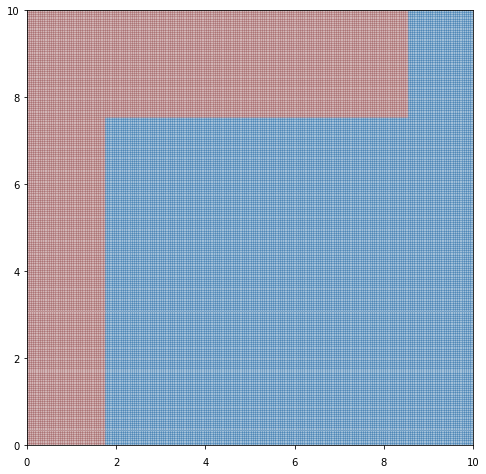

In [43]:
from matplotlib import colors
x_min, x_max = 0, 10
y_min, y_max = 0, 10
cmap = colors.ListedColormap(['steelblue', '#a76c6e'])

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

# Put the result into a color plot
Z = Z.reshape(XX.shape)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
ax.pcolormesh(XX, YY, Z, cmap=cmap, alpha=0.5, zorder=1)    

In [36]:
Z

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

### Part 4: AdaBoost for Handwritten Digits 
***

Use your AdaBoost code with Sklearn's DecisionTreeClassifier as the base learner to distinguish $3$'s from $8$'s. 
Run $n=500$ boosting iterations with trees of depths 1, 2, and 3 (go deeper if you like) as the weak learner. For each weak learner, plot the training and validation error per boosting iteration on the same set of axes (note, the `staged_score` function will be helpful for this). Compare and contrast the different weak learners. Which works the best? Do you see signs of overfitting? Do any of classifiers achieve nearly 100% accuracy on the training data? What happens to the accuracy on the validation data on further iterations?

/Users/julius/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


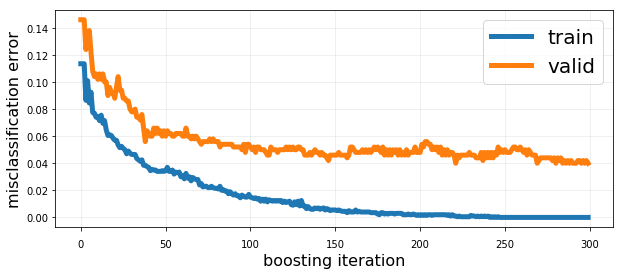

In [19]:
clf = AdaBoost(n_learners=300, base=DecisionTreeClassifier(max_depth=1))# TODO 

clf.fit(data.X_train, data.y_train) # TODO
train_scores = clf.staged_score(data.X_train, data.y_train) # TODO 
valid_scores = clf.staged_score(data.X_valid, data.y_valid) # TODO 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
ax.plot(1 - train_scores, label="train")
ax.plot(1 - valid_scores, label="valid")
ax.set_xlabel("boosting iteration", fontsize=16)
ax.set_ylabel("misclassification error", fontsize=16)
ax.grid(alpha=0.25)
ax.legend(loc="upper right", fontsize=20)

/Users/julius/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


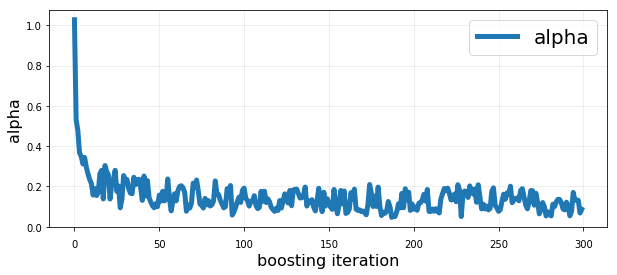

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
ax.plot(clf.alpha, label="alpha")
ax.set_xlabel("boosting iteration", fontsize=16)
ax.set_ylabel("alpha", fontsize=16)
ax.grid(alpha=0.25)
ax.legend(loc="upper right", fontsize=20)

/Users/julius/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


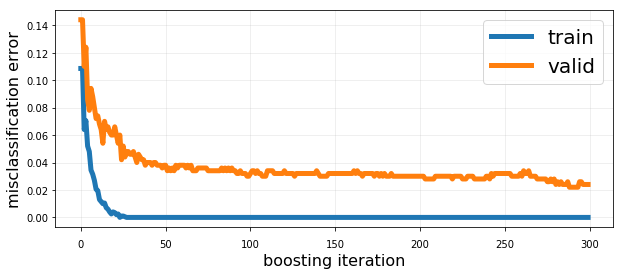

In [22]:
clf = AdaBoost(n_learners=300, base=DecisionTreeClassifier(max_depth=2))# TODO 

clf.fit(data.X_train, data.y_train) # TODO
train_scores = clf.staged_score(data.X_train, data.y_train) # TODO 
valid_scores = clf.staged_score(data.X_valid, data.y_valid) # TODO 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
ax.plot(1 - train_scores, label="train")
ax.plot(1 - valid_scores, label="valid")
ax.set_xlabel("boosting iteration", fontsize=16)
ax.set_ylabel("misclassification error", fontsize=16)
ax.grid(alpha=0.25)
ax.legend(loc="upper right", fontsize=20)

/Users/julius/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


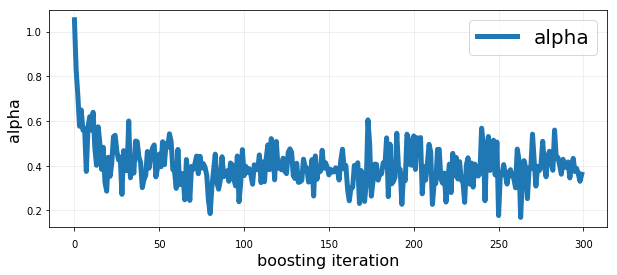

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
ax.plot(clf.alpha, label="alpha")
ax.set_xlabel("boosting iteration", fontsize=16)
ax.set_ylabel("alpha", fontsize=16)
ax.grid(alpha=0.25)
ax.legend(loc="upper right", fontsize=20)

/Users/julius/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


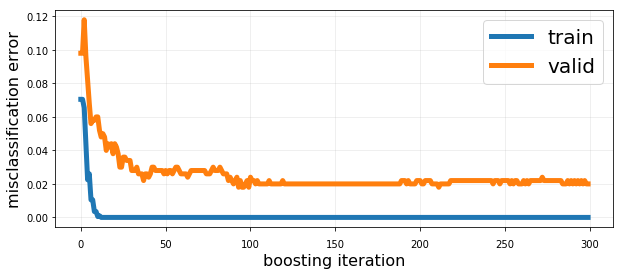

In [24]:
clf = AdaBoost(n_learners=300, base=DecisionTreeClassifier(max_depth=3))# TODO 

clf.fit(data.X_train, data.y_train) # TODO
train_scores = clf.staged_score(data.X_train, data.y_train) # TODO 
valid_scores = clf.staged_score(data.X_valid, data.y_valid) # TODO 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
ax.plot(1 - train_scores, label="train")
ax.plot(1 - valid_scores, label="valid")
ax.set_xlabel("boosting iteration", fontsize=16)
ax.set_ylabel("misclassification error", fontsize=16)
ax.grid(alpha=0.25)
ax.legend(loc="upper right", fontsize=20)

/Users/julius/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


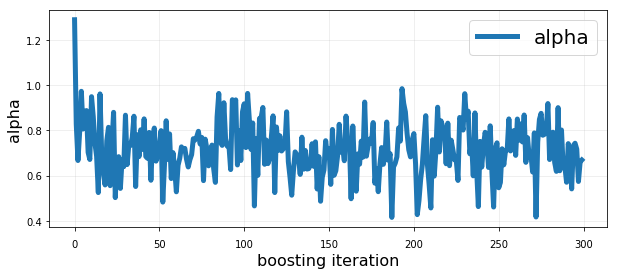

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
ax.plot(clf.alpha, label="alpha")
ax.set_xlabel("boosting iteration", fontsize=16)
ax.set_ylabel("alpha", fontsize=16)
ax.grid(alpha=0.25)
ax.legend(loc="upper right", fontsize=20)

/Users/julius/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


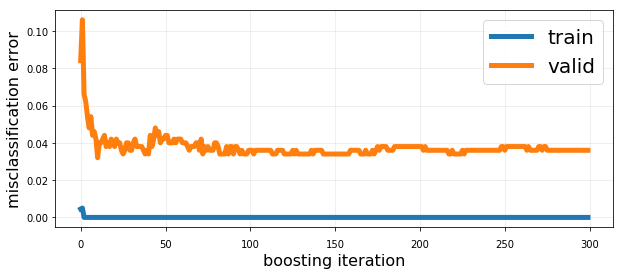

In [26]:
clf = AdaBoost(n_learners=300, base=DecisionTreeClassifier(max_depth=10))# TODO 

clf.fit(data.X_train, data.y_train) # TODO
train_scores = clf.staged_score(data.X_train, data.y_train) # TODO 
valid_scores = clf.staged_score(data.X_valid, data.y_valid) # TODO 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
ax.plot(1 - train_scores, label="train")
ax.plot(1 - valid_scores, label="valid")
ax.set_xlabel("boosting iteration", fontsize=16)
ax.set_ylabel("misclassification error", fontsize=16)
ax.grid(alpha=0.25)
ax.legend(loc="upper right", fontsize=20)

/Users/julius/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


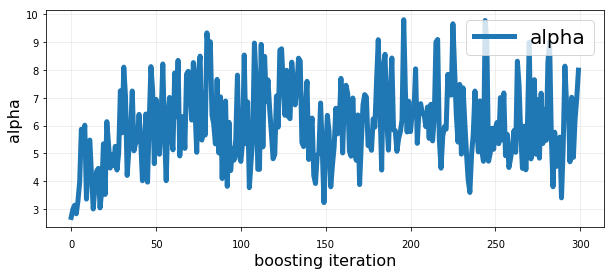

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
ax.plot(clf.alpha, label="alpha")
ax.set_xlabel("boosting iteration", fontsize=16)
ax.set_ylabel("alpha", fontsize=16)
ax.grid(alpha=0.25)
ax.legend(loc="upper right", fontsize=20)